<a href="https://colab.research.google.com/github/nanopiero/fusion/blob/main/notebooks/training_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plan d'expérience:

Régression

      - A1.radar + cmls -> pluvios  [xrl_yp1]
      - A2.radar + cmls -> pluvios1min + pluvios60min [xrl_yp1p60]

Régression + spatialisation

    - B1.radar + pluvio 1 min + cmls -> pluvios 1 min/1 h [xrlp1_yp1p60]

    - B2.radar + pluvio 1 min + cmls -> pluvios 1 min/1 h (+ CMLs) [xrlp1_yp1p60(l)]

    - B3.radar + pluvio 1 min + cmls -> pluvios 1 min/1 h (+ radar) [xrlp1_yp1p60(l)]

    - B4.radar + pluvio 1 min + cmls -> pluvios 1 min/1 h (+ CMLs + radar) [xrlp1_yp1p60(l)]


Régression faiblement supervisée

    - C1. introduction d'un bruit dans les CMLs

    - C2. correction de l'effet du bruit dans les CMLs dans la loss (weak. sup.)

    - C3. correction de l'effet du bruit par un réseau auxilaire (// denoising)





In [1]:
! git clone https://github.com/nanopiero/fusion.git

Cloning into 'fusion'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 172 (delta 103), reused 148 (delta 96), pack-reused 7
Receiving objects: 100% (172/172), 7.47 MiB | 4.17 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [2]:
# Imports des bibliothèques utiles
# pour l'IA
import torch
# pour les maths
import numpy as np
# pour afficher des images et des courbes
import matplotlib.pyplot as plt

from random import randint
import os

# imports des fichiers locaux
os.chdir('fusion')
import utile_fusion
# import importlib
# importlib.reload(utile_fusion)

# Import des fonctions génératrices exploitées à l'échelle de l'image
from utile_fusion import spatialized_gt, create_cmls_filter
# Import loading tools
from utile_fusion import FusionDataset
from torch.utils.data import DataLoader
# Import des fonctions utilisées à l'échelle du batch, sur carte GPU
from utile_fusion import indices_to_sampled_values, get_point_measurements, point_gt, segment_gt, make_noisy_images
# Import cost functions
from utile_fusion import QPELoss_fcn, compute_metrics
# Import des fonctions de visualisation
from utile_fusion import set_tensor_values2, plot_images, plot_images_10pts_20seg, plot_results_10pts_20seg


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Régressions simples

In [4]:
# config de base (change en B.):
npoints = 10
npairs = 20
nsteps = 60
ndiscs = 5
size_image=64
length_dataset = 6400
device = torch.device('cuda:0')

In [5]:
# Dataset, DataLoader
dataset = FusionDataset(length_dataset=length_dataset,
                        npairs=npairs,
                        nsteps=nsteps,
                        ndiscs=ndiscs, size_image=size_image)


loader = DataLoader(dataset, batch_size=64, num_workers=4)

# A1. Radar + CMLS -> pluvios 1min  [xrl_yp1]

In [ ]:
# Petit UNet
from utile_fusion import UNet
ch_in = 72
ch_out = nsteps * 3
size = nsteps * 3

model = UNet(ch_in, ch_out, size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
criterion = QPELoss_fcn()

# Baseline with a FCN
use_fcn = True

best_loss = [float('inf'), float('inf')]  # Initialize best validation loss to a very high value
train_losses = []

In [ ]:
path = r'/content/drive/MyDrive/rainCell/fusion/models/checkpoint_fcn_08062024.pt'

checkpoint = torch.load(path, \
                            map_location=device)
last_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
# best_loss = checkpoint['best_loss']
model_weights = checkpoint['model']
optimizer_state_dict = checkpoint['optimizer']
# scheduler_state_dict = checkpoint['scheduler']
# model.load_state_dict(model_weights)
# optimizer.load_state_dict(optimizer_state_dict)
# scheduler.load_state_dict(scheduler_state_dict)

In [ ]:
model.train()
for epoch in range(100):

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)
  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # for transformers :
    # segment_measurements = segment_gt(images, pairs, filters)
    _, segment_measurements_fcn = segment_gt(images, pairs, filters,
                                             use_fcn=use_fcn)

    # pseudo pluvios
    _, point_measurements_fcn, _ = point_gt(images, npoints=npoints,
                                            use_fcn=use_fcn)


    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn


    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    regression_loss, segmentation_loss, loss, batch_cm = criterion(model.p, outputs, targets)
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    del inputs, targets, outputs, loss, noisy_images, images, pairs, filters
    torch.cuda.empty_cache()

    running_regression_loss += regression_loss
    running_segmentation_loss += segmentation_loss
    train_confusion_matrix += batch_cm

  # Calculating average training loss
  train_regression_loss = running_regression_loss / len(loader)
  train_segmentation_loss = running_segmentation_loss / len(loader)
  train_losses.append((epoch, train_regression_loss, train_segmentation_loss, train_confusion_matrix))
  print(f'Training, Regression Loss: {train_regression_loss:.4f}, Segmentation Loss:{train_segmentation_loss:.4f}' )
  print("Train Confusion Matrix:")
  print(train_confusion_matrix)
  accuracy, csi, sensitivity, specificity, false_alarm_ratio = compute_metrics(train_confusion_matrix)
  print(f'Accuracy: {accuracy:.4f}, CSI: {csi:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, False Alarm Ratio: {false_alarm_ratio:.4f}')
  print('\n')


In [ ]:
#100 époques : 2h28

# checkpoint = {
#     'epoch': epoch,
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
#     # 'scheduler': scheduler.state_dict(),
#     'train_losses': train_losses,
#     }
# torch.save(checkpoint, path)

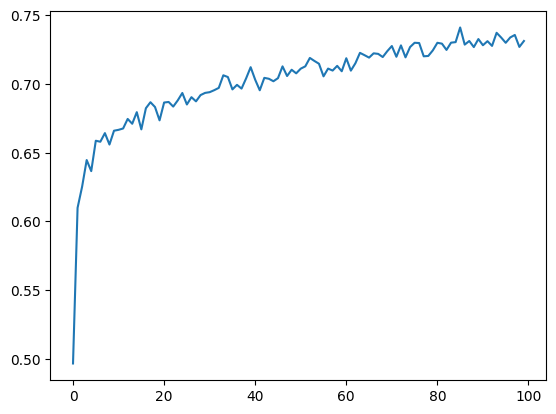

In [ ]:
i = -1
j = 1
csi_values = [compute_metrics(x[i])[j] for x in train_losses]
plt.plot(csi_values)

In [ ]:
# Tracé output
model.eval()

with torch.no_grad():

  running_regression_loss = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)

  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # generation point and segment measurements
    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements, segment_measurements_fcn = segment_gt(images, pairs, filters, use_fcn=use_fcn)

    # pseudo pluvios
    point_measurements, point_measurements_fcn, (indices, rows, cols) = \
                        point_gt(images, npoints=npoints, use_fcn=use_fcn)

    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn
    outputs = model(inputs)
    mask_rnr = outputs[:, :nsteps,...] < outputs[:, nsteps:2*nsteps,...]
    images_pred = (mask_rnr * outputs[:, 2*nsteps:3*nsteps, ...]).detach()

    # segment_measurements = segment_gt(images, pairs, filters)
    segment_measurements_pred, _ = segment_gt(images_pred,
                                              pairs,
                                              filters,
                                              use_fcn=use_fcn)

    # pseudo pluvios
    sampled_values_pred = indices_to_sampled_values(images_pred, indices)
    point_measurements_pred = get_point_measurements(rows, cols,
                                                     sampled_values_pred,
                                                     size_image)

    break



k=0

"""
plot_images_10pts_20seg(3*images_pred[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
            noisy_images[k,...].cpu().numpy(),
            point_measurements[k,...].cpu().numpy(),
            segment_measurements[k,...].cpu().numpy())
"""

plot_results_10pts_20seg(3*images[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
                         noisy_images[k,...].cpu().numpy(),
                         point_measurements[k,...].cpu().numpy(),
                         segment_measurements[k,...].cpu().numpy(),
                         3*images_pred[k,...].cpu().numpy() + filters[k,...].cpu().numpy().sum(axis=0),
                         (images_pred[k, torch.arange(4, 60, 5), ...] > 0).long().cpu().numpy(),
                         point_measurements_pred[k,...].cpu().numpy(), #_pred)
                         segment_measurements_pred[k,...].cpu().numpy()) #_pred)



# A2. Radar + CMLS -> pluvios 1min  [xrl_yp1p60]

In [ ]:
# Petit UNet
from utile_fusion import UNet
ch_in = 72
ch_out = nsteps * 3 + 1
size = nsteps * 3

model = UNet(ch_in, ch_out, size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
class QPELoss_fcn(nn.Module):
    def __init__(self, cumuls_1h = False):
        super(QPELoss_fcn, self).__init__()
        self.regression_loss = nn.MSELoss()
        self.segmentation_loss = nn.CrossEntropyLoss()
        self.cumuls_1h = cumuls_1h

    def forward(self, p, outputs, targets):

      # sans supervision imparfaite, avec spatialisation

      bs, nsteps, S, _ = targets.shape
      targets = targets.view(bs, 1, nsteps, S**2)
      mask = (targets>=0)
      masked_targets = targets[mask]
      outputs_rnr0 = outputs[:, :nsteps, ...].view(bs, 1, nsteps, S**2)
      outputs_rnr1 = outputs[:, nsteps:2*nsteps, ...].view(bs, 1, nsteps, S**2)
      masked_output_rnr = torch.cat([outputs_rnr0[mask].view(bs, 1, -1), outputs_rnr1[mask].view(bs, 1, -1)], dim=1)
      masked_target_rnr =  (masked_targets > 0).long().view(bs, -1)
      output_qpe = outputs[:, 2*nsteps:3*nsteps , ...]\
                                .view(bs, 1, nsteps, S**2)

      masked_output_qpe = output_qpe[mask][masked_targets > 0]
      masked_target_qpe = masked_targets[masked_targets > 0]


      loss_rnr = self.segmentation_loss(masked_output_rnr, masked_target_rnr)



      loss_qpe_1min = self.regression_loss(masked_output_qpe, masked_target_qpe)



      loss = 1/(2*p[0]**2) * loss_qpe_1min + 1/(2*p[1]**2) * loss_rnr


      if self.cumuls_1h:
        loss_qpe_1h = self.regression_loss(output_qpe.sum(dim=1)[mask[:,0,...]],
                                           targets.sum(dim=1)[mask[:,0,...]])
        loss += 1/(2*p[2]**2) * loss_qpe_1h
        loss += torch.log(1 + p[0]**2 + p[1]**2 + p[2]**2)

      else:
        loss+= torch.log(1+p[0]**2+p[1]**2)

      with torch.no_grad():
        preds = masked_output_rnr.argmax(dim=1).flatten().cpu().numpy()
        targets = masked_target_rnr.flatten().cpu().numpy()
        # Compute the confusion matrix
        cm = confusion_matrix(targets, preds, labels=np.arange(2))
      # loss_qpe_5min =

      # loss_fusion1 =

      # avec supervision imparfaite + spatialisation


      # avec supervision imparfaite + spatialisation + denoinsing

      # avec supervision imparfaite + spatialisation + denoising + GAN


      if self.cumuls_1h:
        return loss_qpe_1min.item(), loss_qpe_1h.item(), loss_rnr.detach().item(), loss, cm
      else:
        return loss_qpe_1min.item(), loss_rnr.detach().item(), loss, cm



In [ ]:
criterion = QPELoss_fcn(cumuls_1h=True)

# Baseline with a FCN
use_fcn = True

best_loss = [float('inf'), float('inf')]  # Initialize best validation loss to a very high value
train_losses = []

In [ ]:
path = r'/content/drive/MyDrive/rainCell/fusion/models/checkpoint_fcn_08062024.pt'

checkpoint = torch.load(path, \
                            map_location=device)
last_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
# best_loss = checkpoint['best_loss']
model_weights = checkpoint['model']
optimizer_state_dict = checkpoint['optimizer']


In [ ]:
model.train()
for epoch in range(100):

  running_regression_loss = 0.0
  running_regression_loss_1h = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)
  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # for transformers :
    # segment_measurements = segment_gt(images, pairs, filters)
    _, segment_measurements_fcn = segment_gt(images, pairs, filters,
                                             use_fcn=use_fcn)

    # pseudo pluvios
    _, point_measurements_fcn, _ = point_gt(images, npoints=npoints,
                                            use_fcn=use_fcn)


    # pseudo radar
    noisy_images = make_noisy_images(images)

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn


    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    regression_loss, regression_loss_1h, segmentation_loss, loss, batch_cm = criterion(model.p, outputs, targets)
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    del inputs, targets, outputs, loss, noisy_images, images, pairs, filters
    torch.cuda.empty_cache()

    running_regression_loss += regression_loss
    running_regression_loss_1h += regression_loss_1h
    running_segmentation_loss += segmentation_loss
    train_confusion_matrix += batch_cm

  # Calculating average training loss
  train_regression_loss = running_regression_loss / len(loader)
  train_regression_loss_1h = running_regression_loss_1h / len(loader)
  train_segmentation_loss = running_segmentation_loss / len(loader)
  train_losses.append((epoch, train_regression_loss, train_regression_loss_1h, train_segmentation_loss, train_confusion_matrix))
  print(f'Training, Regression Loss: {train_regression_loss:.4f}, Regression Loss 1h: {train_regression_loss_1h:.4f}, Segmentation Loss:{train_segmentation_loss:.4f}' )
  print("Train Confusion Matrix:")
  print(train_confusion_matrix)
  accuracy, csi, sensitivity, specificity, false_alarm_ratio = compute_metrics(train_confusion_matrix)
  print(f'Accuracy: {accuracy:.4f}, CSI: {csi:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, False Alarm Ratio: {false_alarm_ratio:.4f}')
  print('\n')


Training, Regression Loss: 0.1360, Regression Loss 1h: 0.0591, Segmentation Loss:0.2741
Train Confusion Matrix:
[[3082358  115481]
 [ 281709  360452]]
Accuracy: 0.8966, CSI: 0.4758, Sensitivity: 0.5613, Specificity: 0.9639, False Alarm Ratio: 0.2426


Training, Regression Loss: 0.0933, Regression Loss 1h: 0.0362, Segmentation Loss:0.2079
Train Confusion Matrix:
[[3095922   98132]
 [ 189279  456667]]
Accuracy: 0.9252, CSI: 0.6137, Sensitivity: 0.7070, Specificity: 0.9693, False Alarm Ratio: 0.1769


Training, Regression Loss: 0.0823, Regression Loss 1h: 0.0320, Segmentation Loss:0.1959
Train Confusion Matrix:
[[3102389   93972]
 [ 174996  468643]]
Accuracy: 0.9300, CSI: 0.6354, Sensitivity: 0.7281, Specificity: 0.9706, False Alarm Ratio: 0.1670


Training, Regression Loss: 0.0729, Regression Loss 1h: 0.0296, Segmentation Loss:0.1887
Train Confusion Matrix:
[[3102513   93444]
 [ 168824  475219]]
Accuracy: 0.9317, CSI: 0.6444, Sensitivity: 0.7379, Specificity: 0.9708, False Alarm Ratio: 0

KeyboardInterrupt: 

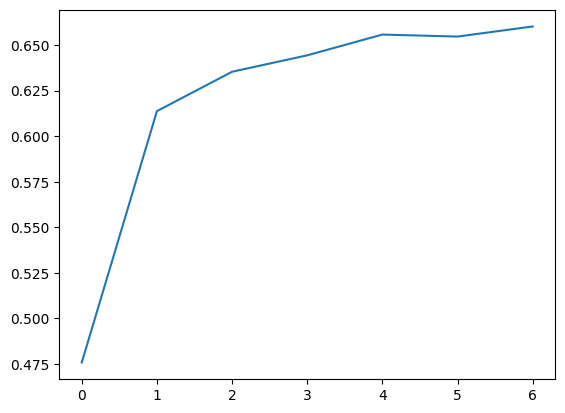

In [ ]:
i = -1
j = 1
csi_values = [compute_metrics(x[i])[j] for x in train_losses]
plt.plot(csi_values)

# B. Régression + spatialisation

# B1. Radar + pluvios + CMLS -> pluvios 1min pluvios 60 min [xrlp1_yp1p60]

In [ ]:
def segment_gt(images, pairs, filters, use_fcn=False):
  bs, nsteps, S, _ = images.shape
  _, nlinks, _, _ = filters.shape

  filters[filters == 0] = torch.nan
  filtered_images = images.unsqueeze(dim=2) * \
                    filters.unsqueeze(dim=1)
  # on ajoute 0.1 pour distinguer du cas == 0
  sampled_values = torch.nanmean(filtered_images,\
                    dim=(3,4))
  segment_measurements = torch.cat((pairs, sampled_values), dim=1)
  filters[filters != filters] = 0

  if not use_fcn:
    return segment_measurements, None
  else:
    sampled_values += 0.1
    filters = filters.unsqueeze(1)
    filters = filters * sampled_values.view(bs, nsteps, nlinks, 1, 1)
    filters = filters.sum(dim=2)
  return segment_measurements, filters


def generate_indices_rows_and_columns(images, npoints):
  bs, nsteps, S, _ = images.shape
  weights = torch.ones(S**2).expand(bs, -1).to(images.device)
  indices = torch.multinomial(weights, num_samples=npoints, replacement=False) #.to(images.device)

  # Calculate coordinates from indices
  rows = indices // S
  cols = indices % S

  # Gather the values from these indices for all images
  indices = indices.unsqueeze(dim=1).repeat([1,nsteps,1])
  return indices, rows, cols



def indices_to_sampled_values(images, indices):
  bs, nsteps, S, _ = images.shape
  flat_images = images.view(bs, nsteps, S * S)

  # Gather the values from these indices for all images
  sampled_values = torch.gather(flat_images, 2, indices)
  return sampled_values




def get_point_measurements(rows, cols, sampled_values, S=64):
  # Normalize coordinates to be between 0 and 1
  ys = (1 - rows.float()/S) - 1/(2*S)
  xs = cols.float()/S + 1/(2*S)

  # Stack the normalized coordinates with the values
  point_measurements = torch.cat((xs.unsqueeze(1),
                      ys.unsqueeze(1),
                      sampled_values), dim=1)
  return point_measurements





def point_gt(images, npoints=10, use_fcn=False, split=None): #Split: (1,10,10) : signifie : pluvio n°0 à n-1 dans inputs avec n choisi entre 1 et 9. Le difficile: faire ça par batch.
  bs, nsteps, S, _ = images.shape

  indices, rows, cols = generate_indices_rows_and_columns(images, npoints)

  sampled_values = indices_to_sampled_values(images, indices)
  point_measurements = get_point_measurements(rows, cols, sampled_values, S)

  if not use_fcn:
    return point_measurements, None, (indices, rows, cols)

  else:
    # Difference with point_gt:
    point_measurements_fcn = -0.1 * torch.ones(images.numel(), device=images.device)
    indices_batch = torch.arange(bs).repeat(60)
    # indice du premier élément de la i ème image pour le premier time step dans images.flatten()
    idx_i000=(torch.arange(bs, device = images.device) * nsteps).view(bs,1).expand(bs,nsteps)
    # indices du premier élément de la i ème image pour le premier time step j dans images.flatten()
    idx_ij00=idx_i000 + torch.arange(nsteps, device = images.device).view(1,nsteps).expand(bs,nsteps)
    # indices à conserver :
    idx_ijkl = S**2 * idx_ij00.unsqueeze(-1) + indices
    point_measurements_fcn[idx_ijkl.flatten()] = sampled_values.flatten()

    point_measurements_fcn = point_measurements_fcn.view(bs, nsteps, S, S)

    return point_measurements, point_measurements_fcn, (indices, rows, cols)


In [ ]:
# config de base (change en B.):
npoints = 20 # 20 utilisés pour l'entraînement, 10
npairs = 20
nsteps = 60
ndiscs = 5
size_image=64
length_dataset = 6400
device = torch.device('cuda:0')

# Dataset, DataLoader
dataset = FusionDataset(length_dataset=length_dataset,
                        npairs=npairs,
                        nsteps=nsteps,
                        ndiscs=ndiscs, size_image=size_image)


loader = DataLoader(dataset, batch_size=64, num_workers=4)

In [ ]:
# Petit UNet V1 : on conserve des champs indépendants pour les pluvios -> 60 champs supplémentaires
from utile_fusion import UNet
ch_in = 72 + 60
ch_out = nsteps * 3 + 1
size = nsteps * 3

model = UNet(ch_in, ch_out, size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
model.train()
for epoch in range(100):

  running_regression_loss = 0.0
  running_regression_loss_1h = 0.0
  running_segmentation_loss = 0.0
  train_confusion_matrix = np.zeros((2, 2), dtype=int)
  for i, (images, pairs, filters) in enumerate(loader):

    # ground truth (not usable)
    images = images.clone().detach().float().to(device)

    # pseudo CMLs
    pairs = pairs.clone().detach().float().to(device)
    filters = filters.clone().float().detach().to(device)

    # for transformers :
    # segment_measurements = segment_gt(images, pairs, filters)
    _, segment_measurements_fcn = segment_gt(images, pairs, filters,
                                             use_fcn=use_fcn)

    # pseudo pluvios + split input, target, val
    _, point_measurements_fcn, _ = point_gt(images, npoints=npoints,
                                            use_fcn=use_fcn, split=True)




    # pseudo radar
    noisy_images = make_noisy_images(images)

    #

    # prepare inputs and targets
    inputs = torch.cat([noisy_images, segment_measurements_fcn], dim=1)
    targets = point_measurements_fcn


    optimizer.zero_grad()  # Zero the gradients
    outputs = model(inputs)  # Forward pass

    regression_loss, regression_loss_1h, segmentation_loss, loss, batch_cm = criterion(model.p, outputs, targets)
    loss.backward()  # Backward pass
    optimizer.step()  # Update the weights

    del inputs, targets, outputs, loss, noisy_images, images, pairs, filters
    torch.cuda.empty_cache()

    running_regression_loss += regression_loss
    running_regression_loss_1h += regression_loss_1h
    running_segmentation_loss += segmentation_loss
    train_confusion_matrix += batch_cm

  # Calculating average training loss
  train_regression_loss = running_regression_loss / len(loader)
  train_regression_loss_1h = running_regression_loss_1h / len(loader)
  train_segmentation_loss = running_segmentation_loss / len(loader)
  train_losses.append((epoch, train_regression_loss, train_regression_loss_1h, train_segmentation_loss, train_confusion_matrix))
  print(f'Training, Regression Loss: {train_regression_loss:.4f}, Regression Loss 1h: {train_regression_loss_1h:.4f}, Segmentation Loss:{train_segmentation_loss:.4f}' )
  print("Train Confusion Matrix:")
  print(train_confusion_matrix)
  accuracy, csi, sensitivity, specificity, false_alarm_ratio = compute_metrics(train_confusion_matrix)
  print(f'Accuracy: {accuracy:.4f}, CSI: {csi:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, False Alarm Ratio: {false_alarm_ratio:.4f}')
  print('\n')
